In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

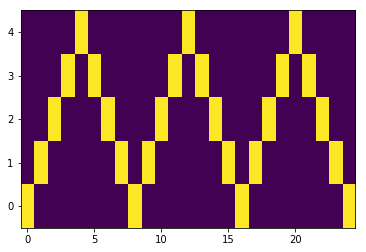

In [2]:
observed = np.zeros((25, 1, 5))

pos = 0
vel = +1
for t in range(0, observed.shape[0]):
    observed[t, 0, pos] = 1
    pos += vel
    
    if (pos <= 0) or (pos >= observed.shape[-1] - 1):
        vel = -vel
        
plt.imshow(observed[:, 0, :].T, interpolation='none', origin='lower', aspect='auto')

In [3]:
# modeled after: https://arxiv.org/pdf/1511.05121.pdf
tf.reset_default_graph()

x_ = tf.placeholder(tf.float32, shape=[None, None, 5])

time_steps_ = tf.shape(x_)[0]
batch_size_ = tf.shape(x_)[1]

# summarize future observed states
# TODO: learn initial state
x_summary_initial_ = tf.zeros([batch_size_, 10])
x_summary_dense_ = tf.layers.Dense(units=10, activation=tf.nn.relu)

def update_x_summary(current, observed):
    return x_summary_dense_(tf.concat([current, observed], axis=-1))
    

# NOTE: apply in anti-causal direction
x_summary_ = tf.scan(update_x_summary, x_[::-1], x_summary_initial_)
x_summary_ = x_summary_[::-1]

# sample the latent state
initial_loc_ = tf.Variable([0.0, 0.0], dtype=tf.float32)
initial_scale_ = tf.Variable([0.0, 0.0], dtype=tf.float32)

initial_latent_ = initial_loc_ + initial_scale_ * tf.random_normal([batch_size_, 2])

qz_loc_dense_ = tf.layers.Dense(units=2, activation=tf.nn.relu)
qz_scale_dense_ = tf.layers.Dense(units=2, activation=tf.nn.softplus)

def update_qz(current, observed):
    _, _, current = current
    latent_shape_ = tf.shape(current)
    current = tf.concat([current, observed], axis=-1)
    
    loc_ = qz_loc_dense_(current)
    scale_ = qz_scale_dense_(current)
    
    return [loc_, scale_, loc_ + scale_ * tf.random_normal(latent_shape_)]

qz_loc_, qz_scale_, z_ = tf.scan(
    update_qz, x_summary_, [
        tf.tile(tf.expand_dims(initial_loc_, axis=0), [batch_size_, 1]), 
        tf.tile(tf.expand_dims(initial_scale_, axis=0), [batch_size_, 1]),
        initial_latent_,
    ],
)

pz_loc_dense_ = tf.layers.Dense(units=2, activation=tf.nn.relu)
pz_scale_dense_ = tf.layers.Dense(units=2, activation=tf.nn.softplus)

def update_pz(_, latent_):
    return [pz_loc_dense_(latent_), pz_scale_dense_(latent_)]

pz_loc_, pz_scale_ = tf.scan(
    update_pz, z_,
    [
        tf.tile(tf.expand_dims(initial_loc_, axis=0), [batch_size_, 1]), 
        tf.tile(tf.expand_dims(initial_scale_, axis=0), [batch_size_, 1]),
    ],
)

qz_ = tf.distributions.Normal(qz_loc_, qz_scale_)
pz_ = tf.distributions.Normal(pz_loc_, pz_scale_)

px_loc_ = tf.layers.dense(z_, 5, activation=tf.nn.relu)
px_scale_ = tf.layers.dense(z_, 5, activation=tf.nn.softplus)

px_ = tf.distributions.Normal(px_loc_, px_scale_)